## HW_1(Pandas) Анализ характеристик влияющих на успеваемость студентов

### Цель

    Используя библиотеку pandas (или аналоги), проанализировать как можно больше характеристик, влияющих на успеваемость студентов.

### План

1. Загрузка первичное исследование и предобработка данных:
    - Анализ структуры, исправление типов, работа с пропусками
    - Подготовка датасета для дальнейшего анализа: выборка, объединение датасетов, сдвиг данных в колонках prior.
    

2. Исследовательский анализ данных - Анализ характеристик, влияющих на успеваемость:
    - Общий средний процент успеваемости (answered_correctly).
    - Средний процент успеваемости в разрезе тем (part) вопросов.
    - Анализ зависимости среднего времени (question_elapsed_time) на ответ и успеваемости.
    - Анализ зависимости успеваемости от получения обратной связи (question_had_explanation).
    - Анализ зависимости успеваемости и количества просмотренных лекций (контент с content_type_id == 1).
    - Анализ зависимости динамики успеваемости от количества времени (timestamp), проведенного на платформе.

3. Выводы

### Описание источников данных

1. train.csv

    - row_id: (int64) ID code for the row.
    - timestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user.
    - user_id: (int32) ID code for the user.
    - content_id: (int16) ID code for the user interaction
    - content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.
    - task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.
    - user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.
    - answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.
    - prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.
    - prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

2. questions.csv: metadata for the questions posed to users.

    - question_id: foreign key for the train/test content_id column, when the content type is question (0).
    - bundle_id: code for which questions are served together.
    - correct_answer: the answer to the question. Can be compared with the train user_answer column to check if the user was right.
    - part: the relevant section of the TOEIC test.
    - tags: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

3. lectures.csv: metadata for the lectures watched by users as they progress in their education.

    - lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).
    - part: top level category code for the lecture.
    - tag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.
    - type_of: brief description of the core purpose of the lecture.

## Загрузка первичное исследование и предобравботка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
from scipy.stats import ttest_rel
pd.set_option('display.float_format', '{:.2f}'.format)
import warnings 
warnings.filterwarnings('ignore')

### Загрузка и предобработка lectures и questions

In [2]:
# Загрузка данных lectures и questions
lectures_df = pd.read_csv('lectures.csv')
questions_df = pd.read_csv('questions.csv')

In [3]:
display(lectures_df.head())
lectures_df.info()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


In [4]:
print('Явных дубликатов:', lectures_df.duplicated().sum())

Явных дубликатов: 0


Итак всего 418 лекций.
В lectures_df пропусков нет, явных дубликатов тоже. Типы данных корректны, посмотрим на уникальные значения и их количество.

In [5]:
lectures_df[['tag','part','type_of']].nunique()

tag        151
part         7
type_of      4
dtype: int64

In [6]:
print(lectures_df['part'].sort_values().unique())
lectures_df['type_of'].unique()

[1 2 3 4 5 6 7]


array(['concept', 'solving question', 'intention', 'starter'],
      dtype=object)

    Итак, лекции делятся на 7 разделов (part), лекции могут быть сгруппированы по 151 общиму тегу (tag), всего 5 типов (type_of) лекций (старт, цель, концепция и итоговые вопросы).
    С учетом корректности типов данных, отсутствия пропусков и анализа уникальных значений, можно сделать вывод, что данные корректны и какой-либо дополнительной обработки lectures_df не требуется.

In [7]:
display(questions_df.head())
questions_df.info()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


In [8]:
print('Явных дубликатов:', questions_df.duplicated().sum())

Явных дубликатов: 0


In [9]:
#посмотрим на пропуск
questions_df[questions_df['tags'].isna()]

,question_id,bundle_id,correct_answer,part,tags
10033,10033,10033,2,6,NaN


In [10]:
# заполним пропуск модой по признаку part и correct_answer
questions_10033 = questions_df[(questions_df['part'] == 6) & (questions_df['correct_answer'] == 2)]
mode_tags = questions_10033['tags'].mode()
questions_df['tags'] = questions_df['tags'].fillna(mode_tags[0])

In [11]:
questions_df[questions_df['tags'].isna()]

,question_id,bundle_id,correct_answer,part,tags


    Итак, в questions_df всего 13523 вопроса, пропусков нет (была только одна строка tags, ее заполнил модой), явных дубликатов тоже. 
    Типы данных корректны, посмотрим на уникальные значения в категориях и их количество.

In [12]:
questions_df[['tags','part','bundle_id', 'correct_answer']].nunique()

tags              1519
part                 7
bundle_id         9765
correct_answer       4
dtype: int64

In [13]:
print(questions_df['part'].sort_values().unique())
questions_df['correct_answer'].unique()

[1 2 3 4 5 6 7]


array([0, 1, 3, 2], dtype=int64)

    Итак, уникальных тегов (комбинаций tag) 1519 шт, вопросы делятся на 7 частей (как и лекции), вопросы могут идти пакетами, поэтому bundle_id меньше чем самих вопросов, всего 4 варианта правильных ответов.

### Загрузка, предобработка train_df и выборка данных

    Так как размер файла train_df - 5 Гб, для обработки его средствами pandas потребуется доступный объем RAM, превышающий  имеющийся в моей системе. Поэтому для предобработки и выборки данных для дальнейшего анализа, используем библиотеку dask, которая использует ленивые вычисления и может справляться с датасетами больших размеров при ограниченных системных ресурсах.

In [14]:
# явно пропишем нужные колонки для загрузки и типы данных, исходя из описания
data_types = {
    'row_id': 'int32',
    'timestamp': 'int64',
    'user_id': 'int64',
    'content_id': 'int16',
    'content_type_id': 'int8',
    'task_container_id': 'int16',
    'user_answer': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float32',
    'prior_question_had_explanation': 'boolean'
}
# Загрузка данных train
train_df = dd.read_csv("train.csv", dtype=data_types, usecols=list(data_types.keys()))

In [15]:
#посмотрим на размер датасета
print(train_df.shape[0].compute())
print(train_df.shape[1])

101230332.0
10


train_df содержит более 101 млн. строк и 10 колонок.

In [16]:
#посмотрим на несколько строк и типы данных
display(train_df.tail())
train_df.dtypes

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
1080606,101230327,428564420,2147482888,3586,0,22,0,1,18000.00,True
1080607,101230328,428585000,2147482888,6341,0,23,3,1,14000.00,True
1080608,101230329,428613475,2147482888,4212,0,24,3,1,14000.00,True
1080609,101230330,428649406,2147482888,6343,0,25,1,0,22000.00,True
1080610,101230331,428692118,2147482888,7995,0,26,3,1,29000.00,True


row_id                              int32
timestamp                           int64
user_id                             int64
content_id                          int16
content_type_id                      int8
task_container_id                   int16
user_answer                          int8
answered_correctly                   int8
prior_question_elapsed_time       float32
prior_question_had_explanation    boolean
dtype: object

In [17]:
#посмотрим на количество уникальных пользователей платформы
train_df.user_id.nunique().compute()

393656

In [18]:
# посмотрим на уникальные значения в content_type_id, 
#user_answer, answered_correctly, prior_question_elapsed_time, prior_question_had_explanation
print(train_df.user_answer.unique().compute())
print()
print(train_df.answered_correctly.unique().compute())
print()
print(train_df.prior_question_had_explanation.unique().compute())
print()
print(train_df.content_type_id.unique().compute()) 

0    3
0    2
0    0
0    1
0   -1
Name: user_answer, dtype: int8

0    0
0    1
0   -1
Name: answered_correctly, dtype: int8

0    False
0     True
0     <NA>
Name: prior_question_had_explanation, dtype: boolean

0    0
0    1
Name: content_type_id, dtype: int8


Варианты уникальных данных соответствуют представленному к датасету описанию. В prior_question_had_explanation видны пропуски.

In [19]:
# посмотрим на answered_correctly 
train_df['answered_correctly'].value_counts().compute()

answered_correctly
 0    34026673
 1    65244627
-1     1959032
Name: count, dtype: int64

В основном данные об ответах (1-верно, 0 -неверно и -1 - посмотр лекций)

In [20]:
# посмотрим на пропуски 
train_df.isnull().sum().compute()

row_id                                  0
timestamp                               0
user_id                                 0
content_id                              0
content_type_id                         0
task_container_id                       0
user_answer                             0
answered_correctly                      0
prior_question_elapsed_time       2351538
prior_question_had_explanation     392506
dtype: int64

От общего количества строк в 101 млн., количество пропусков не значительно, кроме того: 

    1. в prior_question_elapsed_time пропуски должны быть, так как в этой колонке отражается время ответа на вопрос, а для строк с лекциями это поле не релевантно, плюс в этой колонке отражается среднее время ответа на предыдущий вопрос, а для первого вопроса такой информации нет, поэтому пропуски здесь также могут быть.

    2. Информация в  строках prior_question_had_explanation также относятся к предыдущей строке, поэтому для первого вопроса, также должны быть пропуски. 
    
    Проверим, сколько пропусков prior_question_elapsed_time, prior_question_had_explanation, если timestamp == 0. 


In [21]:
train_df[(train_df['timestamp'] == 0) & (train_df['prior_question_had_explanation'].isna()) & (
    train_df['prior_question_elapsed_time'].isna())].shape[0].compute()

392441.0

    Вывод:
    1. Итак, большая часть пропусков prior_question_had_explanation и часть prior_question_elapsed_time подтвержденно относятся к первым взаимодействиям пользователей системы, когда информации об истории предыдущего взаимодействия не было.
    Поэтому эти строки не удаляем, а после выборки сдвинем информацию в них на 1 строку вверх, а пропуски в последних строках заполним медианами (для времени) и модой, для количества прослушанных лекций.
    2. При этом остались еще 65 строк (392506-392441), пропуски в которых не относятся к первым строкам с timestamp == 0. Посмотрим на них. 

In [22]:
train_df[(train_df['timestamp'] != 0) & (train_df['prior_question_had_explanation'].isna()) & (
    train_df['prior_question_elapsed_time'].isna())].compute().head(2)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
441303,1631931,12231,34683777,4784,0,1,1,1,NaN,<NA>
836400,7791632,10632,169503292,6120,0,1,1,1,NaN,<NA>


In [23]:
train_df[train_df['user_id'] == 34683777].compute().head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
441302,1631930,0,34683777,24697,1,0,-1,-1,NaN,False
441303,1631931,12231,34683777,4784,0,1,1,1,NaN,<NA>
441304,1631932,29782,34683777,4472,0,2,3,1,7000.00,True
441305,1631933,70272,34683777,6269,0,3,1,0,11000.00,True
441306,1631934,110792,34683777,6191,0,4,1,1,17000.00,True


    Вывод:
    
    Последние 65 строк с пропусками есть у пользователей, которые в первом своем действии посмотрели лекцию, а вторым ответили на вопрос, а так как для лекции время ответа не отслеживается, то в prior_question_elapsed_time пропуск обоснован, так же как и prior_question_had_explanation, так как не было  вопроса, чтобы его объяснять.
    
    Общий вывод, выявленные пропуски в колонках prior_question_elapsed_time и prior_question_had_explanation обоснованы и не требуют заполнений или удаления, так как:
        1. относятся к строкам с лекциями, где не отслеживается время ответа и не должно быть пояснений к отвеченным вопросам.
        2. относятся к первым взаимодействиям пользователя с системой, соответственно нет истории о времени ответа на предыдущий вопрос, так как его еще не было. Соответственно и объяснений вопроса просто не могло быть.
        3. небольшая часть пользователей иммет пропуски во втором взаимодействии в том случае, если первое взаимодействие было - прослушивание лекции, а не ответ на вопрос.
        Итоговый вывод - пропуски оставляем, а после выборки сдвинем информацию в них на 1 строку вверх, а пропуски в последних строках заполним медианами (для времени) и модой, для количества прослушанных лекций.

Заменим тип данных в prior_question_had_explanation с bolean на float для дальнейшего анализа.

In [26]:
train_df['prior_question_had_explanation'] = train_df['prior_question_had_explanation'].fillna(np.nan).astype(float)

In [27]:
print(train_df.shape[0].compute())
print(train_df.shape[1])

101230332.0
10


In [28]:
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.00,0.00
2,2,118363,115,128,0,0,0,1,55000.00,0.00
3,3,131167,115,7860,0,3,0,1,19000.00,0.00
4,4,137965,115,7922,0,4,1,1,11000.00,0.00


    Итак, данные train_df загрузили, проверили, что имеющиеся пропуски корректны.
    Можно сделать выборку, чтобы далее работать с ней в pandas.

#### Выборка данных train_df

    Так как речь идет о данных представленных в виде временных рядов динамики обучения студентов, а также имеющих логичный дисбаланс в целевой метрике (успеваемость), то простая рандомная выборка не подойдет.
    Сделаем выборку, которая бы учитывала как дисбаланс, так и не рушила временные ряды отдельных студентов.
    В итоговую выборку возьмем 10% от train_df - это будет 10 млн. записей, что должно быть достаточно для дальнейшего анализа.

In [29]:
# Рассчитаем среднее значение answered_correctly для каждого пользователя
user_accuracy = train_df.query('content_type_id == 0').groupby(
    'user_id')['answered_correctly'].mean().compute()

# Определим пороговые значения для стратификации
high_accuracy_threshold = 0.75
low_accuracy_threshold = 0.25

# Разделим пользователей на группы в зависимости от среднего значения answered_correctly
high_accuracy_users = user_accuracy[user_accuracy >=
                                    high_accuracy_threshold].index
medium_accuracy_users = user_accuracy[(user_accuracy < high_accuracy_threshold) & (
    user_accuracy > low_accuracy_threshold)].index
low_accuracy_users = user_accuracy[user_accuracy <=
                                   low_accuracy_threshold].index

# Установим долю выборки 10%
sample_fraction = 0.1
np.random.seed(42)

# Выбираем случайное подмножество пользователей из каждой группы
sampled_high_accuracy_users = np.random.choice(high_accuracy_users, size=int(
    len(high_accuracy_users) * sample_fraction), replace=False)
sampled_medium_accuracy_users = np.random.choice(medium_accuracy_users, size=int(
    len(medium_accuracy_users) * sample_fraction), replace=False)
sampled_low_accuracy_users = np.random.choice(low_accuracy_users, size=int(
    len(low_accuracy_users) * sample_fraction), replace=False)

# Объединяем всех выбранных пользователей
sampled_user_ids = np.concatenate(
    [sampled_high_accuracy_users, sampled_medium_accuracy_users, sampled_low_accuracy_users])

# Фильтруем исходный DataFrame для выборки данных только для выбранных пользователей
sampled_df = train_df.loc[train_df['user_id'].isin(sampled_user_ids)]


In [30]:
print(sampled_df.shape[0].compute())
print(sampled_df.shape[1])

10026676.0
10


In [31]:
sampled_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
1874,1874,0,24418,7900,0,0,2,0,NaN,NaN
1875,1875,24224,24418,7876,0,1,2,0,30000.00,0.00
1876,1876,51020,24418,175,0,2,2,1,20000.00,0.00
1877,1877,70540,24418,1278,0,3,3,1,24000.00,0.00
1878,1878,88142,24418,2065,0,4,1,0,17000.00,0.00


In [32]:
#посмотрим на количество уникальных пользователей выборки
sampled_df['user_id'].nunique().compute()

39364

In [33]:
sampled_df.dtypes

row_id                              int32
timestamp                           int64
user_id                             int64
content_id                          int16
content_type_id                      int8
task_container_id                   int16
user_answer                          int8
answered_correctly                   int8
prior_question_elapsed_time       float32
prior_question_had_explanation    float64
dtype: object

In [34]:
sampled_df.isnull().sum().compute()

row_id                                 0
timestamp                              0
user_id                                0
content_id                             0
content_type_id                        0
task_container_id                      0
user_answer                            0
answered_correctly                     0
prior_question_elapsed_time       230319
prior_question_had_explanation     39254
dtype: int64

    Итак, получена выборка в размере 10 млн. строк или 10% от первоначального датасета (train_df), и  такой же процент уникальных студентов.
    Для дальнейшего анализа необходим убедиться, что основные характеристики полученной выборки соответствуют исходным данным.
    Для этого построим графики распределения основных характеристик оригинального и выборочного датафрейма.

In [35]:
# Функции для построения гистограммы оригинального датафрейма и выборочного по колонке
def plot_histogram(dask_df, column, bins=30):
    """
    Формирует данные для гистограмм оригинального датафрейма и выборочного по колонке.
   
    Параметры:
        df_original (DataFrame): оригинальный DataFrame.
        df_sampled (DataFrame): выборка из оригинального DataFrame.
        column (str): имя столбца для построения гистограммы.
        bins (int): количество бинов для гистограммы.
    """
    # Вычисление гистограммы для каждой части
    hist_data = dask_df[column].map_partitions(lambda part: part.value_counts(bins=bins)).compute()
    
    # Суммируем результаты гистограммы по всем частям
    hist_data = hist_data.groupby(hist_data.index).sum()
    
    # Нормализуем значения, чтобы получить проценты
    hist_data = hist_data / hist_data.sum() * 100
    
    return hist_data.index.mid, hist_data.values  # Возвращаем данные для гистограммы

def plot_comparison_histograms(df_original, df_sampled, column, bins=30):
    """
    Строит гистограммы для оригинальных данных и выборки на основе данных из def plot_histogram.
    
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Построение гистограммы для оригинальных данных
    x, y = plot_histogram(df_original, column, bins=bins)
    axes[0].bar(x, y, width=(x[1] - x[0]), alpha=0.7)
    axes[0].set_title(f'Original_Data: {column}')
    axes[0].set_xlabel("Значения")
    axes[0].set_ylabel("Процент")
    
    # Добавление шкалы Y с шагом 5%
    max_y = max(y)
    axes[0].set_yticks(np.arange(0, max_y + 5, 5))

    # Построение гистограммы для выборки
    x, y = plot_histogram(df_sampled, column, bins=bins)
    axes[1].bar(x, y, width=(x[1] - x[0]), alpha=0.7)
    axes[1].set_title(f'Sampled_Data: {column}')
    axes[1].set_xlabel("Значения")
    axes[1].set_ylabel("Процент")
    
    # Добавление шкалы Y с шагом 5% для выборки
    max_y_sampled = max(y)
    axes[1].set_yticks(np.arange(0, max_y_sampled + 5, 5))

    # Вывод графиков
    plt.tight_layout()
    plt.show()

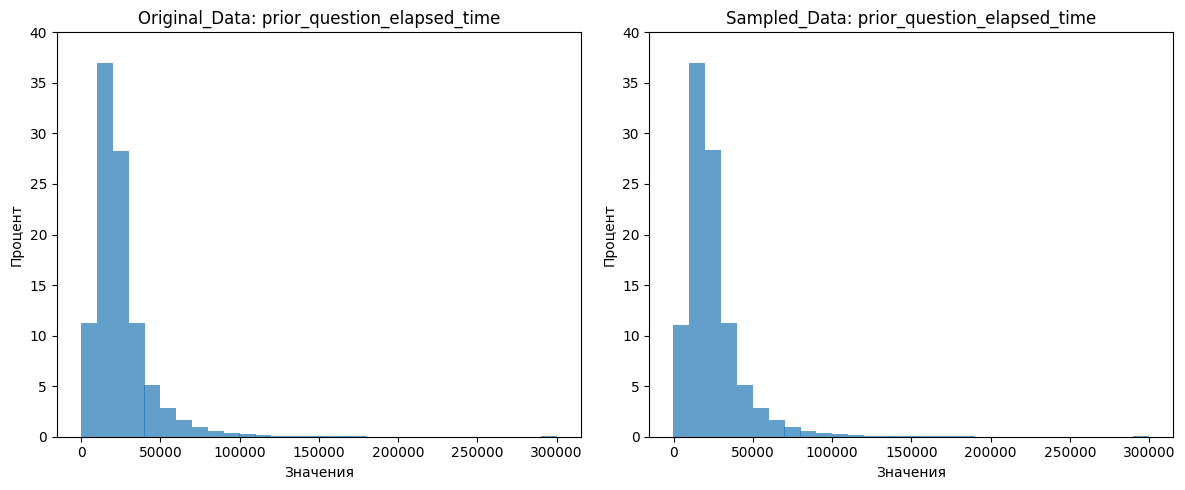

In [36]:
plot_comparison_histograms(train_df, sampled_df, 'prior_question_elapsed_time')

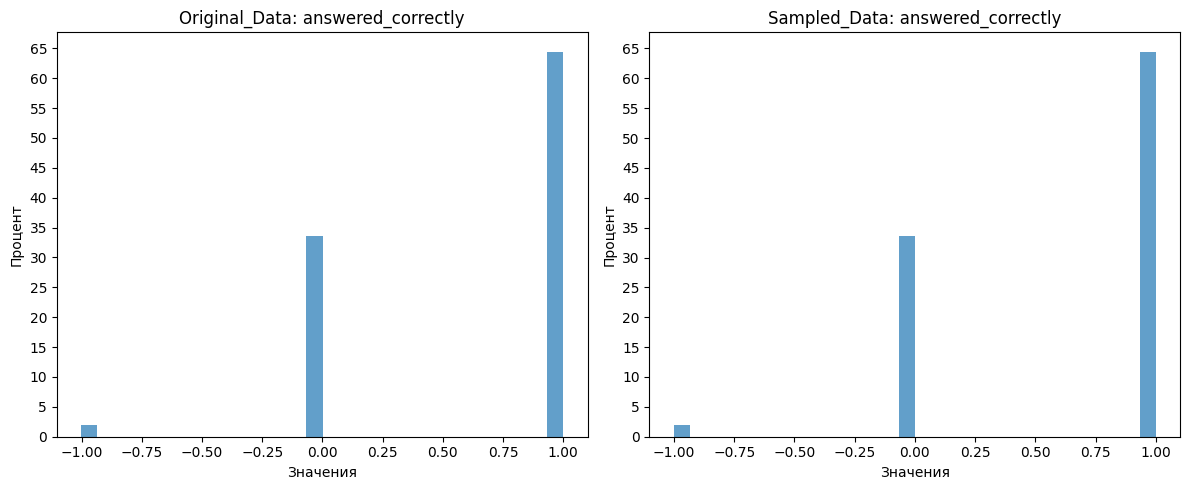

In [37]:
plot_comparison_histograms(train_df, sampled_df, 'answered_correctly')

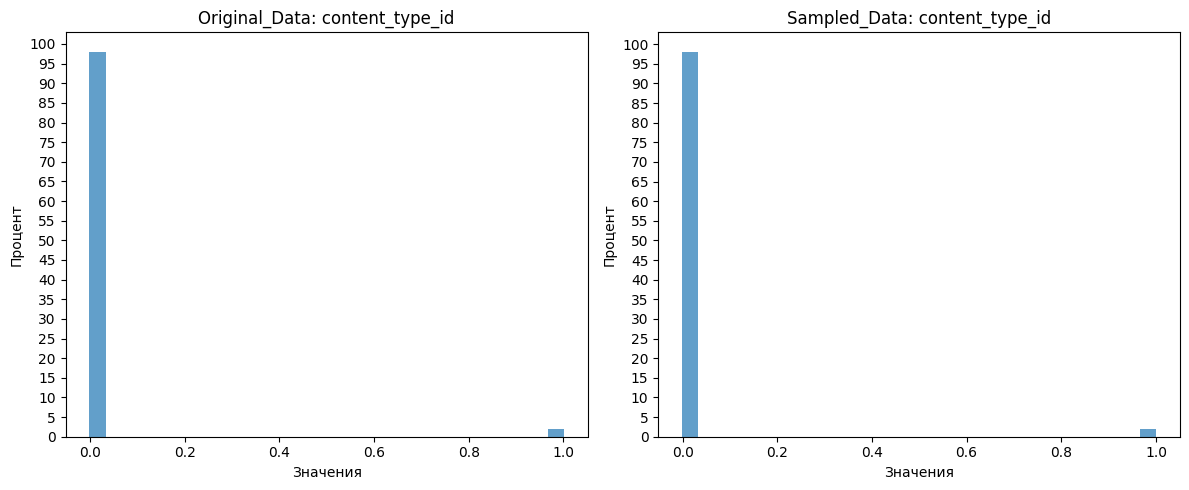

In [38]:
plot_comparison_histograms(train_df, sampled_df, 'content_type_id')

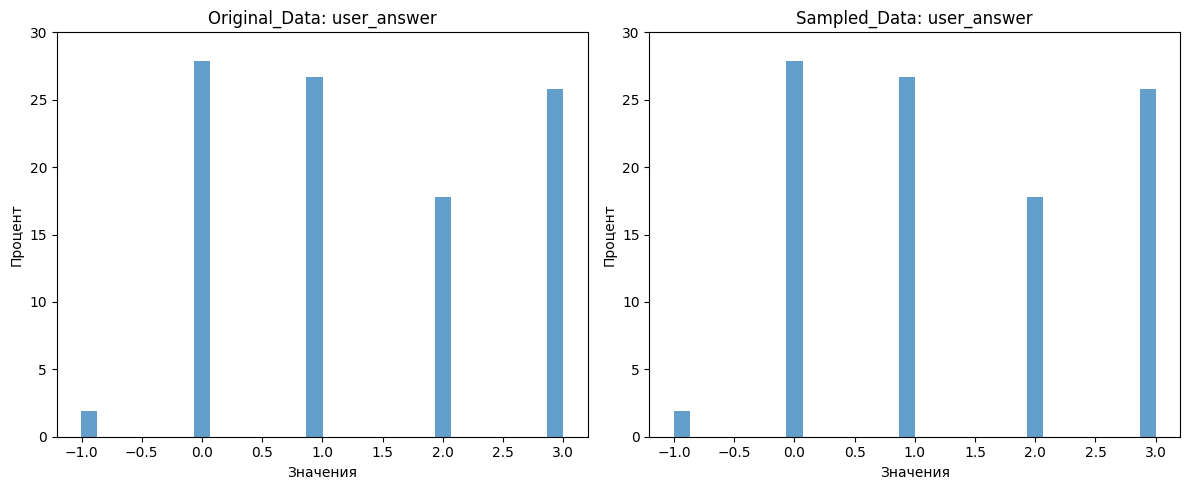

In [39]:
plot_comparison_histograms(train_df, sampled_df, 'user_answer')

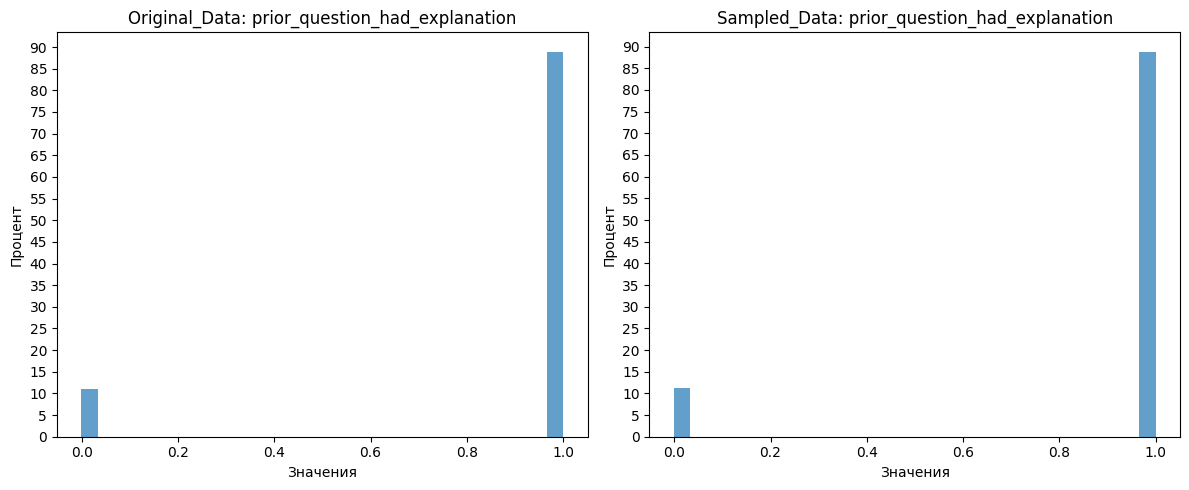

In [40]:
plot_comparison_histograms(train_df, sampled_df, 'prior_question_had_explanation')

Вывод:
    
    Все основные характеристики выборки sampled_df соответствуют оригинальному датафрейму train_df.
    Можно формировать итоговый датафрейм, объединив данные sampled_df, lectures_df и questions_df.

#### Формирование итогового датафрейма для анализа факторов успеваемости

In [41]:
# рассчитаем sampled_df,чтобы далее работать в pandas
sampled_df = sampled_df.compute()

In [42]:
sampled_df.shape

(10026676, 10)

In [43]:
display(sampled_df.head(2))
sampled_df.info()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
1874,1874,0,24418,7900,0,0,2,0,NaN,NaN
1875,1875,24224,24418,7876,0,1,2,0,30000.00,0.00


<class 'pandas.core.frame.DataFrame'>
Index: 10026676 entries, 1874 to 1078788
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int32  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int16  
 4   content_type_id                 int8   
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  float64
dtypes: float32(1), float64(1), int16(2), int32(1), int64(2), int8(3)
memory usage: 449.4 MB


In [44]:
sampled_df.isnull().sum()

row_id                                 0
timestamp                              0
user_id                                0
content_id                             0
content_type_id                        0
task_container_id                      0
user_answer                            0
answered_correctly                     0
prior_question_elapsed_time       230319
prior_question_had_explanation     39254
dtype: int64

##### Корректировка данных в колонках prior_question_had_explanation и prior_question_elapsed_time
    
    

    Согласно описания в строках данных колонок записана информация о предыдущем вопросе: было ли просмотрено объяснение и средне время на ответ.
    Поэтому для корректного анализа нужно сдвинуть данные в этих колонках на 1 строку вверх в разрезе каждого пользователя.
    При этом появятся nan в последних строках по каждому пользователю, заполним их так:
        - для оценки времени ответа используем - среднее/mean()
        - для оценки наличия/отсутствия просмотра объяснения - моду/mode() 

In [45]:
# Фильтруем строки, где content_type_id == 0 (то есть ответы на вопросы)
filtered_sampled_df = sampled_df[sampled_df['content_type_id'] == 0].copy()

# Сдвигаем значения в рамках каждой группы по user_id
filtered_sampled_df['question_elapsed_time'] = filtered_sampled_df.groupby(
    'user_id')['prior_question_elapsed_time'].shift(-1)
 
filtered_sampled_df['question_had_explanation'] = filtered_sampled_df.groupby(
    'user_id')['prior_question_had_explanation'].shift(-1)


# Заполняем NaN средним значением по user_id для 'question_elapsed_time'
filtered_sampled_df['question_elapsed_time'] = filtered_sampled_df.groupby(
    'user_id')['question_elapsed_time'].transform(lambda x: x.fillna(x.mean() if x.mean() > 0 else 0))
# Заполняем NaN модой по user_id для 'question_had_explanation'
filtered_sampled_df['question_had_explanation'] = filtered_sampled_df.groupby('user_id')['question_had_explanation'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 0)
)

# Объединяем оригинальный sampled_df с отбором по лекциям и filtered_sampled_df
shifted_df = pd.concat([sampled_df[sampled_df['content_type_id'] != 0],
                       filtered_sampled_df], ignore_index=True).sort_values(by='row_id')
#filtered_shifted_df
# После объедиения восстановим 0 значения для оставшихся nan строк с лекциями
shifted_df['question_had_explanation'] = shifted_df['question_had_explanation'].fillna(0).astype(int)

shifted_df = shifted_df.drop(
    columns=['prior_question_elapsed_time', 'prior_question_had_explanation'])

Проверим, что код отработал корректно

In [46]:
display(sampled_df.head(4))
display(shifted_df.head(4))
sampled_df.info()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
1874,1874,0,24418,7900,0,0,2,0,NaN,NaN
1875,1875,24224,24418,7876,0,1,2,0,30000.00,0.00
1876,1876,51020,24418,175,0,2,2,1,20000.00,0.00
1877,1877,70540,24418,1278,0,3,3,1,24000.00,0.00


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,question_elapsed_time,question_had_explanation
191065,1874,0,24418,7900,0,0,2,0,30000.00,0
191066,1875,24224,24418,7876,0,1,2,0,20000.00,0
191067,1876,51020,24418,175,0,2,2,1,24000.00,0
191068,1877,70540,24418,1278,0,3,3,1,17000.00,0


<class 'pandas.core.frame.DataFrame'>
Index: 10026676 entries, 1874 to 1078788
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int32  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int16  
 4   content_type_id                 int8   
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  float64
dtypes: float32(1), float64(1), int16(2), int32(1), int64(2), int8(3)
memory usage: 449.4 MB


И пропуски остались только в строках question_elapsed_time, которые относятся к лекциям

In [47]:
shifted_df.isnull().sum()

row_id                           0
timestamp                        0
user_id                          0
content_id                       0
content_type_id                  0
task_container_id                0
user_answer                      0
answered_correctly               0
question_elapsed_time       191065
question_had_explanation         0
dtype: int64

In [48]:
shifted_df[(shifted_df['question_elapsed_time'].isna()) & (shifted_df['content_type_id'] == 1)].shape

(191065, 10)

In [49]:
#скорректируем тип данных к int в question_had_explanation
shifted_df['question_had_explanation'] = shifted_df['question_had_explanation'].astype(int)
shifted_df['question_had_explanation'].unique()

array([0, 1])

Проверим, что основные характеристики данных существенно не изменились.

In [50]:
sampled_df.prior_question_elapsed_time.describe()

count   9796357.00
mean      25470.48
std       19972.77
min           0.00
25%       16000.00
50%       21000.00
75%       29666.00
max      300000.00
Name: prior_question_elapsed_time, dtype: float64

In [51]:
shifted_df.question_elapsed_time.describe()

count   9835611.00
mean      25463.99
std       19939.26
min           0.00
25%       16000.00
50%       21000.00
75%       29666.00
max      300000.00
Name: question_elapsed_time, dtype: float64

#### Объединение датафреймов lectures_df, questions_df, shifted_df в один

In [52]:
lectures_df.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [53]:
questions_df.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


##### Присоединим questions_df

In [54]:
# Фильтруем строки, где content_type_id == 0 (то есть ответы на вопросы)
filtered_sampled_df = shifted_df[shifted_df['content_type_id'] == 0]

# Объединяем с questions_df, используя 'content_id' и 'question_id'
merged_df = filtered_sampled_df.merge(
    questions_df,
    how='left',
    left_on='content_id',
    right_on='question_id'
)
# Обновляем shifted_df новыми значениями
union_df = pd.concat([shifted_df[shifted_df['content_type_id'] != 0],
                     merged_df], ignore_index=True).sort_values(by='row_id')

In [55]:
union_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,question_elapsed_time,question_had_explanation,question_id,bundle_id,correct_answer,part,tags
191065,1874,0,24418,7900,0,0,2,0,30000.00,0,7900.00,7900.00,0.00,1.00,131 93 81
191066,1875,24224,24418,7876,0,1,2,0,20000.00,0,7876.00,7876.00,3.00,1.00,10 94 92
191067,1876,51020,24418,175,0,2,2,1,24000.00,0,175.00,175.00,2.00,1.00,9 10 92
191068,1877,70540,24418,1278,0,3,3,1,17000.00,0,1278.00,1278.00,3.00,2.00,143 140 81 29
191069,1878,88142,24418,2065,0,4,1,0,17000.00,0,2065.00,2063.00,2.00,3.00,136 162 92 29


In [56]:
union_df.isnull().sum()

row_id                           0
timestamp                        0
user_id                          0
content_id                       0
content_type_id                  0
task_container_id                0
user_answer                      0
answered_correctly               0
question_elapsed_time       191065
question_had_explanation         0
question_id                 191065
bundle_id                   191065
correct_answer              191065
part                        191065
tags                        191065
dtype: int64

В присоединённых колонка nan относятся к строкам с лекциями, заполним принзнаком -1, как в других колонках датасета.

In [57]:
union_df[['bundle_id', 'correct_answer', 'part', 'tags']] = union_df[['bundle_id', 'correct_answer', 'part', 'tags']].fillna(-1)
union_df = union_df.rename(columns={'part':'part_question','tags': 'tags_question' })
# удалим ненужный question_id
union_df = union_df.drop('question_id', axis=1)

In [58]:
union_df.isnull().sum()

row_id                           0
timestamp                        0
user_id                          0
content_id                       0
content_type_id                  0
task_container_id                0
user_answer                      0
answered_correctly               0
question_elapsed_time       191065
question_had_explanation         0
bundle_id                        0
correct_answer                   0
part_question                    0
tags_question                    0
dtype: int64

In [59]:
union_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10026676 entries, 191065 to 10026675
Data columns (total 14 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   row_id                    int32  
 1   timestamp                 int64  
 2   user_id                   int64  
 3   content_id                int16  
 4   content_type_id           int8   
 5   task_container_id         int16  
 6   user_answer               int8   
 7   answered_correctly        int8   
 8   question_elapsed_time     float32
 9   question_had_explanation  int32  
 10  bundle_id                 float64
 11  correct_answer            float64
 12  part_question             float64
 13  tags_question             object 
dtypes: float32(1), float64(3), int16(2), int32(2), int64(2), int8(3), object(1)
memory usage: 717.2+ MB


In [60]:
# скорректируем типы данных
union_df['bundle_id'] = union_df['bundle_id'].astype('int16')
union_df['correct_answer'] = union_df['correct_answer'].astype('int8')
union_df['part_question'] = union_df['part_question'].astype('int8')

In [61]:
union_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10026676 entries, 191065 to 10026675
Data columns (total 14 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   row_id                    int32  
 1   timestamp                 int64  
 2   user_id                   int64  
 3   content_id                int16  
 4   content_type_id           int8   
 5   task_container_id         int16  
 6   user_answer               int8   
 7   answered_correctly        int8   
 8   question_elapsed_time     float32
 9   question_had_explanation  int32  
 10  bundle_id                 int16  
 11  correct_answer            int8   
 12  part_question             int8   
 13  tags_question             object 
dtypes: float32(1), int16(3), int32(2), int64(2), int8(5), object(1)
memory usage: 525.9+ MB


Данные questions_df загружены в общий датасет union_df, типы данных скорректированы, новых пропусков нет.

##### Присоединим lectures_df

In [62]:
lectures_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


In [63]:
lectures_df.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [64]:
# Фильтруем строки, где content_type_id == 1 (то есть лекции)
filtered_sampled_df = union_df[union_df['content_type_id'] == 1]

# Объединяем с lectures_df, используя 'content_id' и 'question_id'
merged_df = filtered_sampled_df.merge(
    lectures_df,
    how='left',
    left_on='content_id',
    right_on='lecture_id'
)
# Обновляем union_df новыми значениями
union_df = pd.concat([union_df[union_df['content_type_id'] != 1],
                     merged_df], ignore_index=True).sort_values(by='row_id')

# удалим question_id
union_df = union_df.drop('lecture_id', axis=1)

In [65]:
union_df[union_df['content_type_id'] == 1].head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,question_elapsed_time,question_had_explanation,bundle_id,correct_answer,part_question,tags_question,tag,part,type_of
9835611,1909,684669985,24418,14325,1,22,-1,-1,NaN,0,-1,-1,-1,-1,69.00,2.00,intention
9835612,1963,1373479003,24418,9896,1,76,-1,-1,NaN,0,-1,-1,-1,-1,167.00,5.00,concept
9835613,2009,1623661788,24418,6808,1,121,-1,-1,NaN,0,-1,-1,-1,-1,129.00,2.00,intention
9835614,2049,1975547970,24418,24985,1,162,-1,-1,NaN,0,-1,-1,-1,-1,44.00,5.00,concept
9835615,2058,2065626547,24418,8708,1,171,-1,-1,NaN,0,-1,-1,-1,-1,47.00,5.00,concept


In [66]:
union_df[union_df['content_type_id'] == 0].head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,question_elapsed_time,question_had_explanation,bundle_id,correct_answer,part_question,tags_question,tag,part,type_of
0,1874,0,24418,7900,0,0,2,0,30000.00,0,7900,0,1,131 93 81,NaN,NaN,NaN
1,1875,24224,24418,7876,0,1,2,0,20000.00,0,7876,3,1,10 94 92,NaN,NaN,NaN
2,1876,51020,24418,175,0,2,2,1,24000.00,0,175,2,1,9 10 92,NaN,NaN,NaN
3,1877,70540,24418,1278,0,3,3,1,17000.00,0,1278,3,2,143 140 81 29,NaN,NaN,NaN
4,1878,88142,24418,2065,0,4,1,0,17000.00,0,2063,2,3,136 162 92 29,NaN,NaN,NaN


In [67]:
#заплоним пропуски признаком -1, как лекции
union_df[['type_of', 'part', 'tag']] = union_df[['type_of', 'part', 'tag']].fillna(-1)

In [68]:
union_df.isnull().sum()

row_id                           0
timestamp                        0
user_id                          0
content_id                       0
content_type_id                  0
task_container_id                0
user_answer                      0
answered_correctly               0
question_elapsed_time       191065
question_had_explanation         0
bundle_id                        0
correct_answer                   0
part_question                    0
tags_question                    0
tag                              0
part                             0
type_of                          0
dtype: int64

In [69]:
union_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10026676 entries, 0 to 9835610
Data columns (total 17 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   row_id                    int32  
 1   timestamp                 int64  
 2   user_id                   int64  
 3   content_id                int16  
 4   content_type_id           int8   
 5   task_container_id         int16  
 6   user_answer               int8   
 7   answered_correctly        int8   
 8   question_elapsed_time     float32
 9   question_had_explanation  int32  
 10  bundle_id                 int16  
 11  correct_answer            int8   
 12  part_question             int8   
 13  tags_question             object 
 14  tag                       float64
 15  part                      float64
 16  type_of                   object 
dtypes: float32(1), float64(2), int16(3), int32(2), int64(2), int8(5), object(2)
memory usage: 755.4+ MB


In [70]:
# скорректируем типы данных
union_df['tag'] = union_df['tag'].astype('int16')
union_df['part'] = union_df['part'].astype('int8')

In [71]:
union_df.shape

(10026676, 17)

Вывод:
   
    В итоговом датасете 10 млн. стр., 17 столбцов с основными характеристиками о прогрессе обучения студентов.
    Можно проводить анализ факторов, влияющих на эффективность

## Исследовательский анализ данных - Анализ характеристик, влияющих на успеваемость студентов

План:

 - Общий средний процент успеваемости (answered_correctly).
 - Средний процент успеваемости в разрезе тем (part_question: the relevant section of the TOEIC test) вопросов.
 - Анализ зависимости среднего времени (question_elapsed_time) на ответ и успеваемости.
 - Анализ зависимости успеваемости от получения обратной связи (question_had_explanation).
 - Анализ зависимости успеваемости и количества просмотренных лекций (контент с content_type_id == 1).
 - Анализ зависимости динамики успеваемости от количества времени (timestamp), проведенного на платформе.

### Общий средний процент успеваемости (answered_correctly).

In [72]:
# Отберем датасет без данных о лекциях
union_df_question = union_df[union_df['answered_correctly'] != -1]
union_df_question['answered_correctly'].unique()

array([0, 1], dtype=int8)

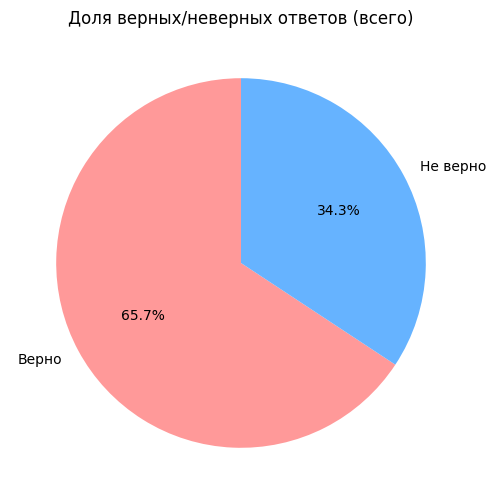

In [73]:
# Считаем доли правильных и неправильных ответов
answered_correctly_counts = union_df_question['answered_correctly'].value_counts(normalize=True)

# Построение круговой диаграммы
plt.figure(figsize=(8, 6))
plt.pie(
    answered_correctly_counts,
    labels=['Верно', 'Не верно'],  
    autopct='%1.1f%%',              
    startangle=90,
    colors=['#ff9999','#66b3ff']      
)
plt.title('Доля верных/неверных ответов (всего)')
plt.show()

Вывод:
    
    Средний процент верных ответов - 66%
    Посмотрим на распределение верных ответов по разделам - part_question. 

### Средний процент успеваемости в разрезе тем (part_question: the relevant section of the TOEIC test) вопросов.

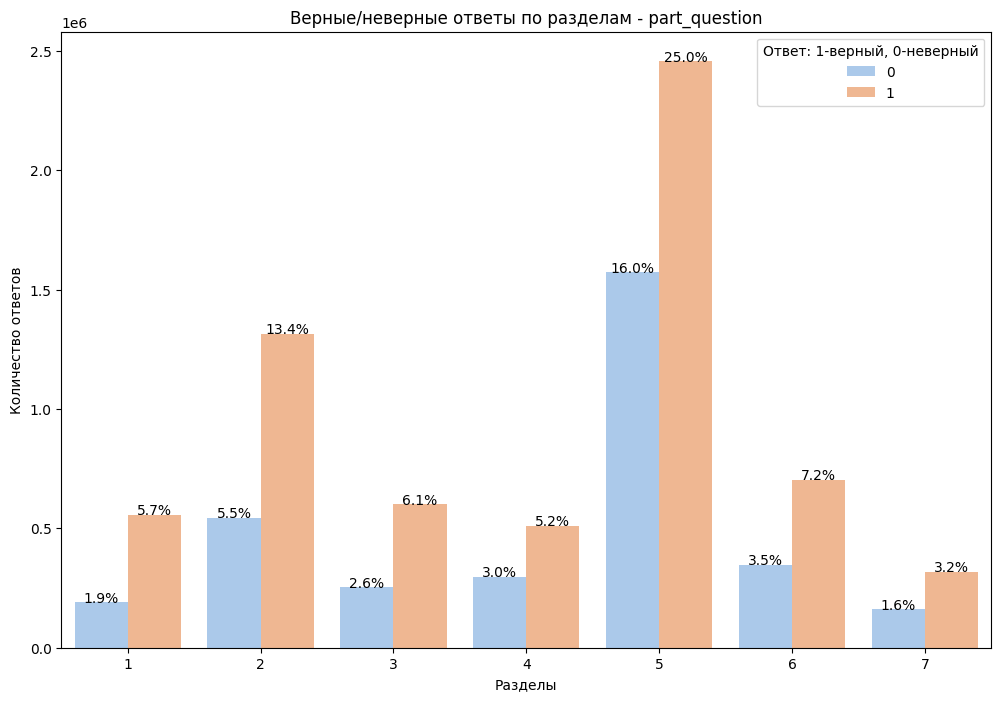

In [74]:
# Построение countplot с разбивкой по правильным/неправильным ответам для каждого part_question
plt.figure(figsize=(12, 8))
g = sns.countplot(
    x='part_question', 
    hue='answered_correctly', 
    data=union_df_question, 
    palette='pastel'
)

# Добавление долей правильных/неправильных ответов в процентах над каждым столбиком
total = float(len(union_df_question))
for p in g.patches:
    height = p.get_height()
    if height > 0:
        g.text(
            p.get_x() + p.get_width() / 2.,
            height + 5,
            '{:1.1f}%'.format((height / total) * 100),
            ha='center'
        )

# Вывод графика
plt.title('Верные/неверные ответы по разделам - part_question')
plt.xlabel('Разделы')
plt.ylabel('Количество ответов')
plt.legend(title='Ответ: 1-верный, 0-неверный')
plt.show()

Вывод:
    
    5-й раздел лидирует как в абсолюте, так и по доле правильных и неправильных ответов студентов.
    Самый отстающий причем как по правильным, так и неправильным ответам- 7-й раздел.

Посмотрим как влияет среднее время ответа на правильность ответов

### Анализ зависимости среднего времени на ответ (question_elapsed_time)  и успеваемости.

In [75]:
# Группировка по каждому студенту (user_id), расчет среднего времени для правильных и неправильных ответов, максимального
# времени в минутах и количества просмотренных лекций и доли верных ответов
student_stats = union_df.groupby('user_id').agg(
    max_time_spent=('timestamp', lambda x: x.max()/60000),
    avg_time_correct=('question_elapsed_time',
                      lambda x: x[union_df.loc[x.index, 'answered_correctly'] == 1].mean()),
    avg_time_incorrect=('question_elapsed_time',
                        lambda x: x[union_df.loc[x.index, 'answered_correctly'] == 0].mean()),
    correct_answers=('answered_correctly', lambda x: (x == 1).sum()),
    incorrect_answers=('answered_correctly', lambda x: (x == 0).sum()),
    count_lectures=('answered_correctly', lambda x: (x == -1).sum())
).reset_index()
student_stats['share_correct_answers'] = student_stats['correct_answers'] / \
    (student_stats['correct_answers'] + student_stats['incorrect_answers'])

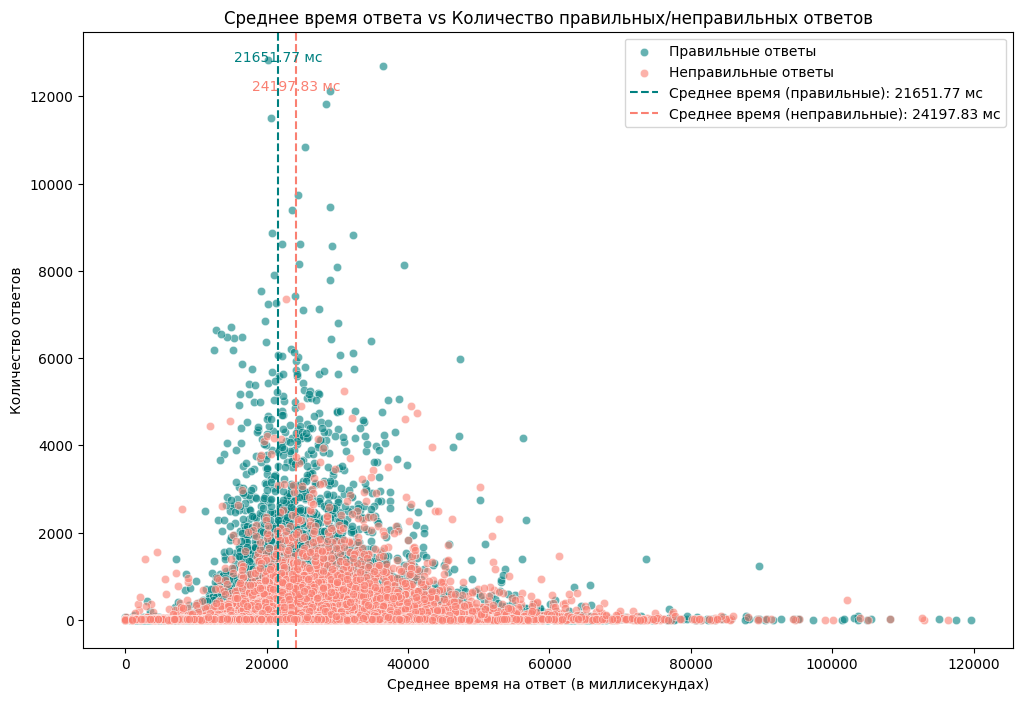

In [76]:
# Общие средние значения для линий времени (медиана) и ответов (среднее) на графике
overall_avg_time_correct = student_stats['avg_time_correct'].median()
overall_avg_time_incorrect = student_stats['avg_time_incorrect'].median()

# Построение scatter plot для правильных ответов
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=student_stats[student_stats['avg_time_correct'] < 140000], # ограничил ось x от выбросов.
    x='avg_time_correct',
    y='correct_answers',
    color='teal',
    label='Правильные ответы',
    alpha=0.6
)

# Построение scatter plot для неправильных ответов
sns.scatterplot(
    data=student_stats[student_stats['avg_time_incorrect'] < 140000],
    x='avg_time_incorrect',
    y='incorrect_answers',
    color='salmon',
    label='Неправильные ответы',
    alpha=0.6
)

# Добавление пунктирных линий для среднего времени на правильные и неправильные ответы и среднего количества ответов
plt.axvline(overall_avg_time_correct, color='teal', linestyle='--',
            label=f'Среднее время (правильные): {overall_avg_time_correct:.2f} мс')
plt.axvline(overall_avg_time_incorrect, color='salmon', linestyle='--',
            label=f'Среднее время (неправильные): {overall_avg_time_incorrect:.2f} мс')

# Подписи для средних линий
plt.text(overall_avg_time_correct, plt.ylim()[
         1] * 0.95, f'{overall_avg_time_correct:.2f} мс', color='teal', ha='center')
plt.text(overall_avg_time_incorrect, plt.ylim()[
         1] * 0.9, f'{overall_avg_time_incorrect:.2f} мс', color='salmon', ha='center')

# Вывод графика
plt.title('Среднее время ответа vs Количество правильных/неправильных ответов')
plt.xlabel('Среднее время на ответ (в миллисекундах)')
plt.ylabel('Количество ответов')
plt.legend()
plt.show()

In [77]:
# Посмотрим на меры центральной тенденции
student_stats.avg_time_correct.describe()

count    39348.00
mean     22956.62
std       8045.70
min          0.00
25%      18166.06
50%      21651.77
75%      26213.24
max     164548.69
Name: avg_time_correct, dtype: float64

In [78]:
student_stats.avg_time_incorrect.describe()

count    39352.00
mean     25376.49
std       8754.99
min          0.00
25%      20140.82
50%      24197.83
75%      29199.03
max     140437.58
Name: avg_time_incorrect, dtype: float64

    Видно, что есть сдвиг в сторону увеличения времени у неправильных ответов. Протестируем эту гипотезу.
        Установим:
            H0. Среднее время для принятия правильного ответа равно среднему времени для принятия неправильного ответа.
            H1. Среднее время для принятия правильного ответа меньше среднего времени необходимого для принятия неправильного ответа.
            Проведем парный ttest, так как у нас есть два связанных измерения (время ответа на правильные и неправильные вопросы) для каждого пользователя, поэтому значения в каждой паре связаны.
            Уровень существенности установим стандартный 0.05
    

In [79]:
# Удаляем строки с пропусками, если у студента были только правильные или только неправильные ответы иначе тест не отработает
cleaned_student_stats = student_stats.dropna(
    subset=['avg_time_correct', 'avg_time_incorrect'])

# Уровень значимости
alpha = 0.05

# Проведение парного t-теста с альтернативной гипотезой "less"
t_stat, p_value = ttest_rel(
    cleaned_student_stats['avg_time_correct'], cleaned_student_stats['avg_time_incorrect'], alternative='less')

# Вывод результатов
print(f"t-статистика: {t_stat}")
print(f"Одностороннее p-значение: {p_value}")

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: среднее время верного ответа статистически значимо меньше среднего времени неверного ответа.")
else:
    print("Не отвергаем нулевую гипотезу: нет статистически значимых доказательств того, что среднее время верного ответа меньше среднего времени неверного ответа.")

t-статистика: -86.52568402555077
Одностороннее p-значение: 0.0
Отвергаем нулевую гипотезу: среднее время верного ответа статистически значимо меньше среднего времени неверного ответа.


Вывод:
    
    В общем, у неправильных ответов есть сдвиг в сторону увеличения времени принятия решения - около +12%.
    Правильный ответ принимается в среднем за 22 секунды (медиана), а неправильный за 24 секунды.
    Статистическая значимость этой дельты подтверждена t-тестом для двух зависимых выборок с уровнем существенности 5%.

### Анализ зависимости успеваемости от получения обратной связи (question_had_explanation).

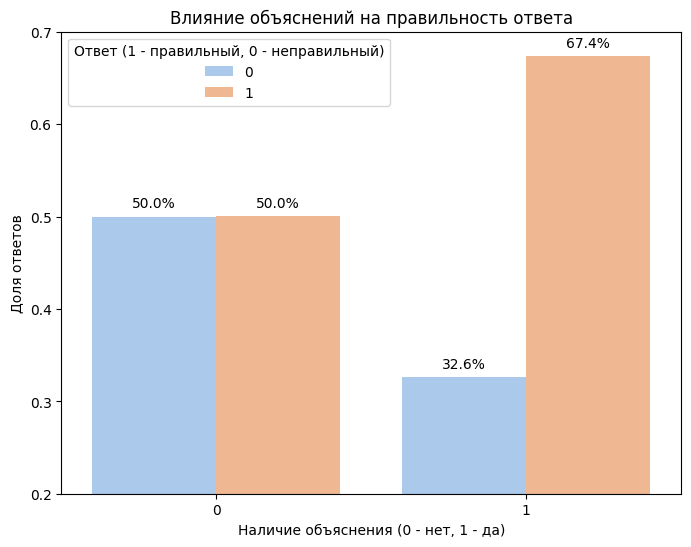

In [80]:
# Подготовка данных для визуализации
explanation_correct = union_df_question.groupby('question_had_explanation')[
    'answered_correctly'].value_counts(normalize=True).rename("share").reset_index()

# Построение столбчатого графика
plt.figure(figsize=(8, 6))
g = sns.barplot(
    data=explanation_correct,
    x='question_had_explanation',
    y='share',
    hue='answered_correctly',
    palette='pastel'
)

# Добавление процентов над столбцами
for p in g.patches:
    height = p.get_height()
    if height > 0:  
        g.text(
            p.get_x() + p.get_width() / 2,
            height + 0.01,
            '{:1.1f}%'.format(height * 100),
            ha='center'
        )

# Вывод графика
plt.ylim(0.2, 0.7)
plt.title('Влияние объяснений на правильность ответа')
plt.xlabel('Наличие объяснения (0 - нет, 1 - да)')
plt.ylabel('Доля ответов')
plt.legend(title='Ответ (1 - правильный, 0 - неправильный)')
plt.show()

Вывод:
    
    Видно, что при наличии обратной связи/объяснений, уровень правильных ответов 67%, что существенно выше доли неправильных 33%.
    При отсутствии обратной связи, доля правильных и неправильных ответов практически равна.

### Анализ зависимости успеваемости и количества просмотренных лекций.

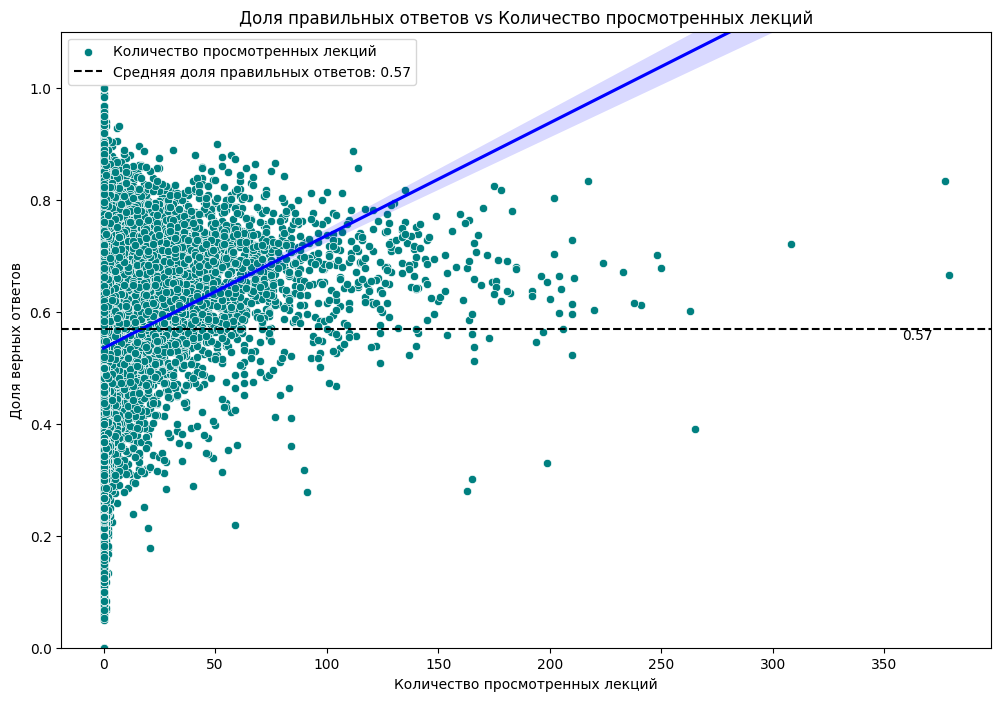

In [81]:
# Общие средние значения для линии доли ответов (медиана) на графике
overall_avg_share_correct_answers = student_stats['share_correct_answers'].median()

# Построение scatter plot 
plt.figure(figsize=(12, 8))

# Построение scatter plot
sns.scatterplot(
    data=student_stats, 
    x='count_lectures',
    y='share_correct_answers',
    color='teal',
    label='Количество просмотренных лекций',
    alpha=1,
)

# Добавление линии тренда
sns.regplot(
    data=student_stats,
    x='count_lectures',
    y='share_correct_answers',
    scatter=False,   # отключаем точки, так как уже построен scatter plot
    color='blue',    
    line_kws={'label': 'Линия тренда'}
)

# Добавление пунктирной линии для средней доли правильных ответов
plt.axhline(overall_avg_share_correct_answers, color='black', linestyle='--',
            label=f'Средняя доля правильных ответов: {overall_avg_share_correct_answers:.2f}')

# Подписи для средних линий
plt.text(plt.xlim()[1] * 0.9, overall_avg_share_correct_answers,
         f'{overall_avg_share_correct_answers:.2f}', color='black', va='top')

min_ylim, max_ylim = plt.ylim(0, 1.1)

# Вывод графика
plt.title('Доля правильных ответов vs Количество просмотренных лекций')
plt.xlabel('Количество просмотренных лекций')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()


Вывод:
        
        На графике четко видна линия тренда, которая показывает, что с ростом числа просмотров лекций, растет и доля правильных ответов студентов.
        

### Анализ динамики успеваемости в зависимости от количества времени, проведенного на платформе

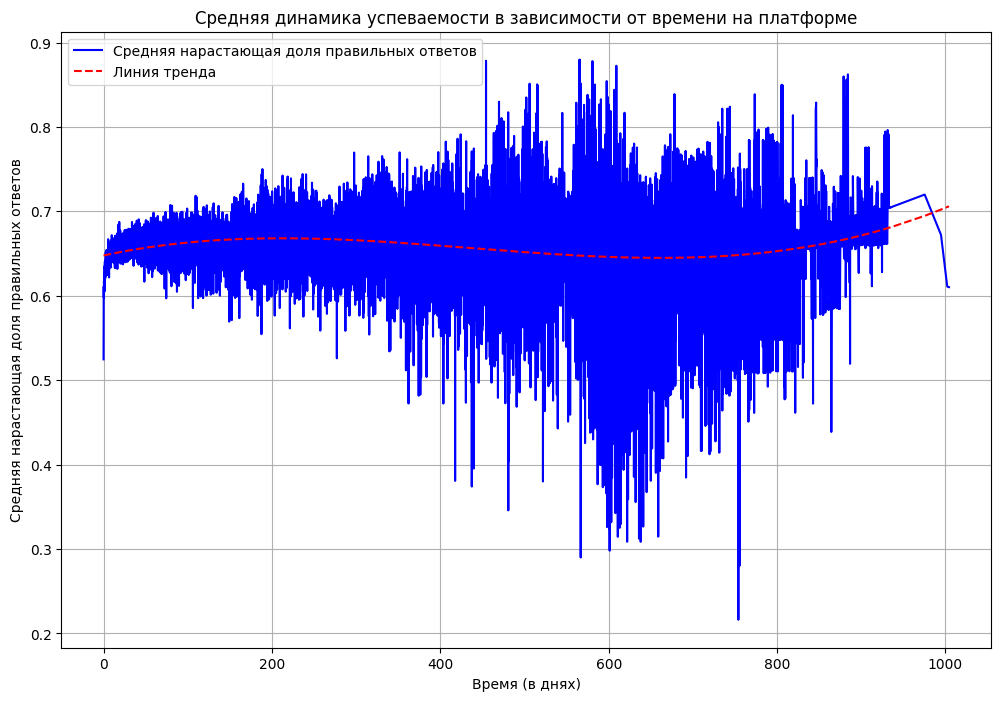

In [82]:
# Конвертируем timestamp в дни 
union_df_question['timestamp_day'] = (union_df_question['timestamp'] / 60000)//60/24

# Группируем по user_id и считаем нарастающее количество правильных и общего количества ответов
union_df_question['cumulative_correct'] = union_df_question.groupby('user_id')['answered_correctly'].cumsum()
union_df_question['cumulative_total'] = union_df_question.groupby('user_id').cumcount() + 1

# Рассчитываем нарастающую долю правильных ответов по каждому user_id
union_df_question['cumulative_accuracy'] = union_df_question['cumulative_correct'] / union_df_question['cumulative_total']

# Агрегируем данные, чтобы получить среднюю нарастающую успеваемость на каждый момент времени
mean_cumulative_accuracy = union_df_question.groupby('timestamp_day')['cumulative_accuracy'].mean()

# Построение графика
plt.figure(figsize=(12, 8))
plt.plot(mean_cumulative_accuracy.index, mean_cumulative_accuracy.values, color='blue', label='Средняя нарастающая доля правильных ответов')

# Добавление линии тренда
x = mean_cumulative_accuracy.index
y = mean_cumulative_accuracy.values
z = np.polyfit(x, y, 3)  # Полином 3-й степени
p = np.poly1d(z)
plt.plot(x, p(x), color='red', linestyle='--', label='Линия тренда')


# Настройка графика
plt.title('Средняя динамика успеваемости в зависимости от времени на платформе')
plt.xlabel('Время (в днях)')
plt.ylabel('Средняя нарастающая доля правильных ответов')
plt.legend()
plt.grid(True)
plt.show()



Вывод:
    
    Видно, что с течением времени нарастает разброс в средних оценках пользователей со снижением снижения общей успеваемости на горизонте от 200 до 700 дней, после чего снова начинается рост.
      Таким образом нет четкой прямой связи между времени на платформе и успеваемостью.

## Общие выводы по анализу характеристик влияющих на успеваемость студентов

    1. Общий средний процент успеваемости - 66%.
    2. Наибольшая доля верных ответов относится к 5 части вопросов - 25%
    2. Анализ зависимости успеваемости и среднего времени на ответ показал, что с увеличением вермени ответа, средняя оценка снижается.
    3. Обратная связь увеличивает процент правильных ответов до 67% против 50% без обратной связи.
    4. Также увеличение количества просмотренных лекций положительно влияет на процент верных ответов.
    5. Анализ динамики успеваемости не выявил четкой прямой связи между количеством времени на платформе и успеваемостью.